# Introduction

The following provides a summary of the steps taken and the observations that led to creation of two different machine models for predicting the dengue outbreaks in San Juan and Iquitos.

In addition but separate from the analysis provided by the authors of this exercise and those illustrate in the benchmark ipynb notebook, a different approach was taken to discover if there are patterns among changing weather conditions and increase/decrease in dengue cases.

1.  The feature and target datasets were merged and then split into San Juan and Iquitos.

2.  Then the null values were filled using average values int eh respective columns.

3.  Next, we looked at the change in total dengue cases and weather parameters across 52 weeks for all years, at both San Juan and Iquitos.

## San Juan

The following show how the increasing average temperatures leads into increasing total cases, several weeks later.

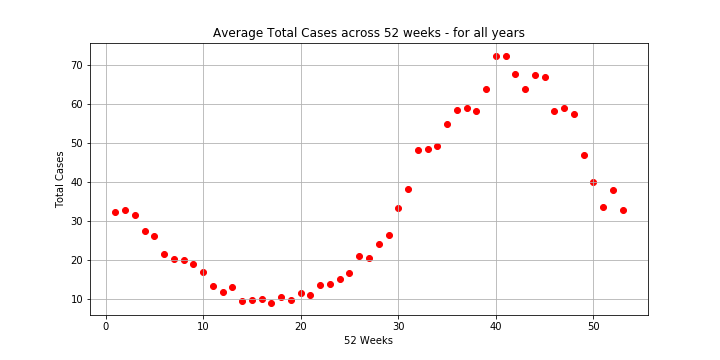

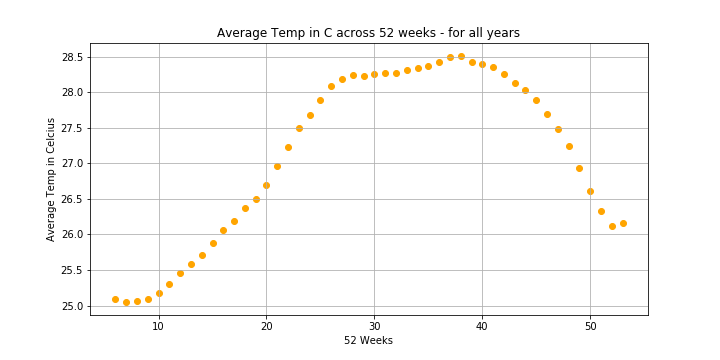

Clearly, there is a correlation between rising average temperatures and rising Dengue cases, but the cases increase several weeks after. As the charts indicate, the increase in total cases of Dengue begins around mid-May in week 20, about 10 weeks AFTER the temperatures started rising (in week 10, early to mid March) to 28 C.  From Mid July to late October, the temperatures stay in the 28 C - 28.5 C, and the cases continue to rise.  

In contrast to the late rise in cases after rise in temperatures, the Dengue cases start declining within couple of weeks after the average temperatures start declining too.

As the following charts illustrate there were also significant changes occuring (rises) among other weather parameters in March, prior to the increase in total cases began.  So the correlations are there, stronger among some weather parameters than others. Similarly, the decline in cases start soon after changes in the other parameters.

This is not an uncommon phenomena.  As the following case study for Dengue cases in Southeast Asis shows, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3854883/  increase and decrease in Dengue cases could follow weeks after changes in weather parameters, ancertain thresholds.  

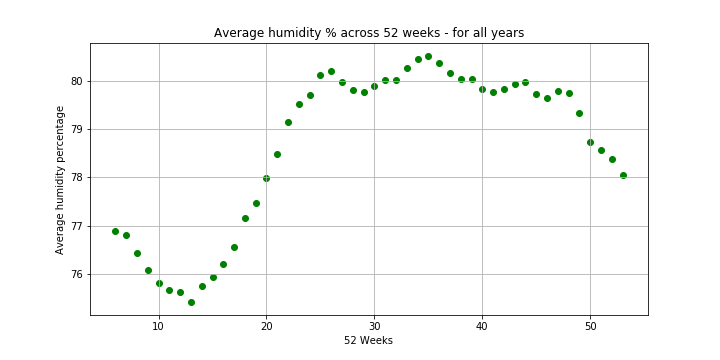

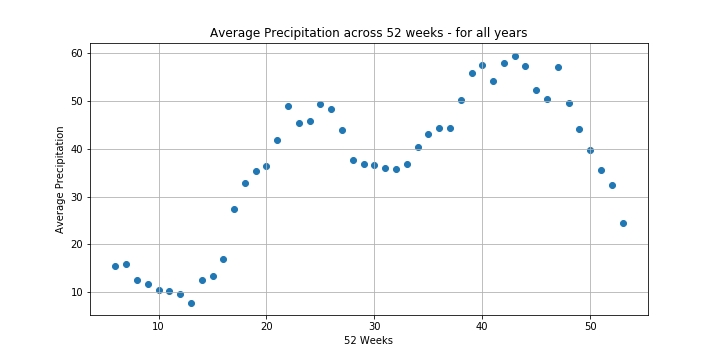

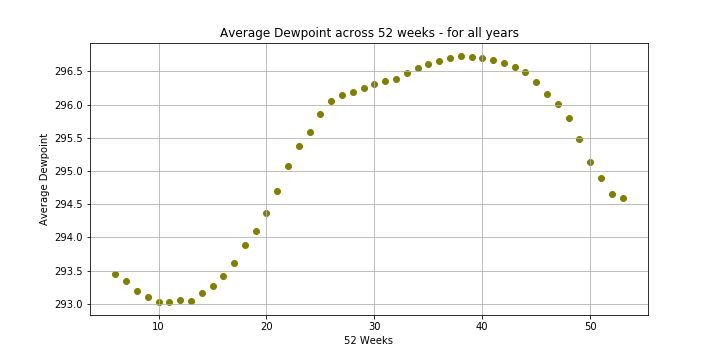

Therefore, new features were created based on rolling averages of the weather parameters that contribute to the changes in the total cases of dengue.  

Next, we derived NEW weather FEATURES that provide historical context for rising, falling, or unchanged trends; FOR EACH actual observation of the primary parameters.  The range from rolling average from a week prior to several weeks prior to the current observation.  This ensures that both the changes in increase and decrease are properly sampled, as the rate of increase are slower and longer, and the rate of decrease is sharper and quicker.

### Avoiding Overfitting

As new features that are used to predict changes in total cases consit of rolling averages, several steps were taken to avoid overfitting.

1. Rolling averages were restricted to 6 week period.  
2. Limited number of previous dewpoint values were used, and several were omitted as they caused higher covariances

## Iquitos

Similar analysis was conducted for the Iquitos.  The changes among all the features (weather parameters) and target (total cases of Dengue) are closer in time, and do not show the lags observed above.

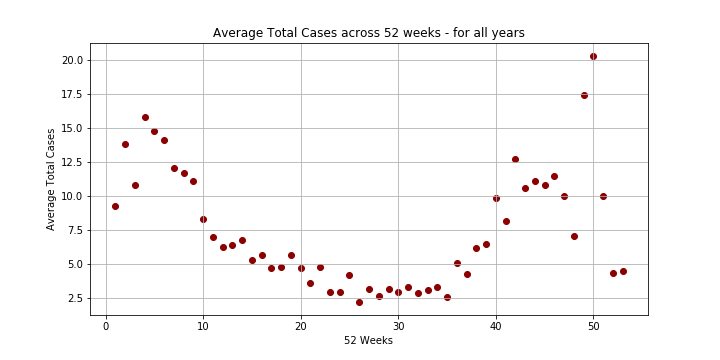

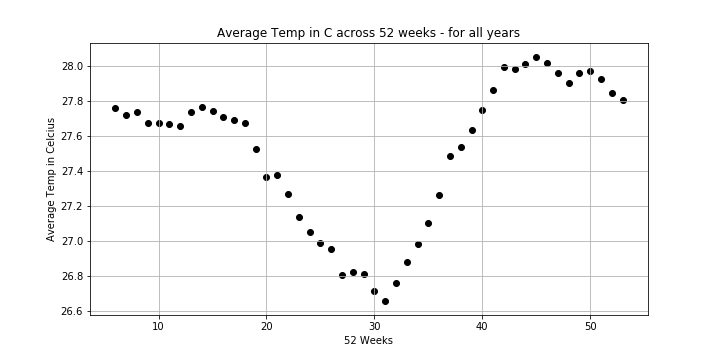

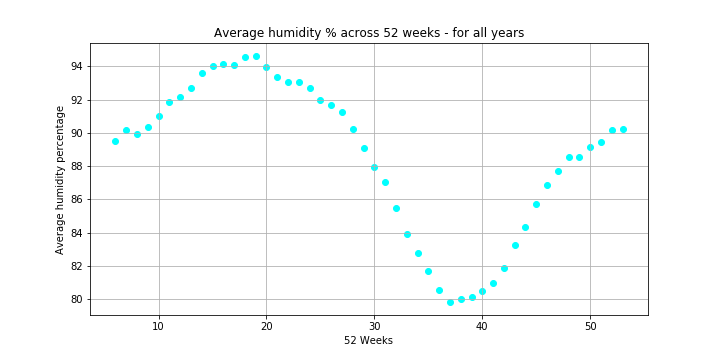

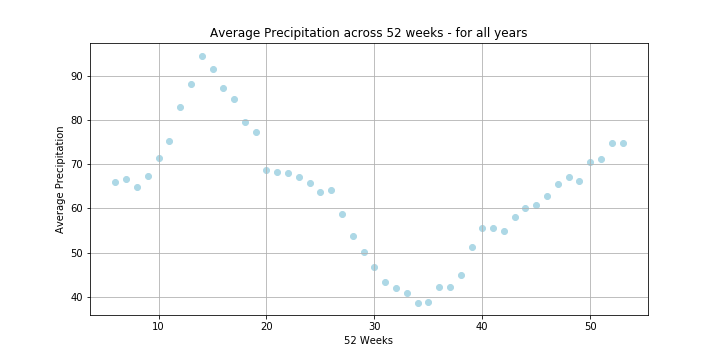

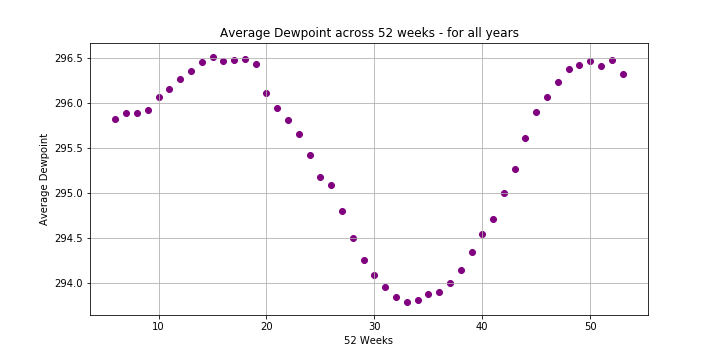

### Avoiding Overfitting

As was the case with San Juan, these steps were taken to avoid overfitting.

1. Rolling averages were restricted to 3 week period, as unlike in San Juan, the changes among features and target (label) appear to occur quickly in Iquitos.
2. In addition to shorter periods for rolling averages, we did not need to look as far bak- weeks at a time- as was the case for San Juan.  In fact,w e only used Current values of the engineered features.

## Import Dependencies

In [68]:
import pandas as pd
import numpy as np

%matplotlib inline

from matplotlib import pyplot as plt

In [69]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [70]:
import statsmodels.formula.api as smf

In [71]:
from statsmodels.tools import eval_measures

In [72]:
import seaborn as sns

## Function to take care of missing values.
The following function is used to replace all NaN values with average of the values in the respective column.

In [73]:
# General function to replace all null values with average of the values in the respective column
def fillnullavg(dtfr):
    for i in range(dtfr.shape[0]): #iterate over rows
        for j in range(dtfr.shape[1]): #iterate over columns
            if pd.isnull(dtfr.iloc[i,j]):
                dtfr.iloc[i,j] = dtfr.iloc[:,j].mean()
    return dtfr                

## Preliminary Data Preprocessing Function

The following function imports both the training features and training labels.  It is different from the formal preprocessing data function used at the end of this notebook to import test features, and make predictions.

In [74]:
def pre_process(X, y):
    dfX = pd.read_csv(X, encoding="ISO-8859-1")
    dfy = pd.read_csv(y, encoding="ISO-8859-1")
    
    #merging the features dataframe and label dataframe for analysis
    df = pd.merge(dfX, dfy, on=['city','year','weekofyear'], how="outer")
    
    #changing the data type of week_start_date to datetime format
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    
    #Split the dataframe into two, one for San Juan and one for Iquitos
    sj = df.loc[df['city'] == 'sj',:]
    iq = df.loc[df['city'] == 'iq',:]
    
    #Fill null values using average of the values in the respective column
    sj = fillnullavg(sj)
    iq = fillnullavg(iq)
    
    # San Juan
    #add new features for San Juan that best predict increase and decrease in total cases:
    sj['roll_temp'] = sj.station_avg_temp_c.rolling(6).mean()
    sj['roll_humid'] = sj.reanalysis_relative_humidity_percent.rolling(6).mean()
    sj['roll_prec'] = sj.reanalysis_sat_precip_amt_mm.rolling(6).mean()
    sj['roll_se'] = sj.ndvi_se.rolling(6).mean()
    sj['roll_sw'] = sj.ndvi_sw.rolling(6).mean()
    sj['roll_dew'] = sj.reanalysis_dew_point_temp_k.rolling(6).mean()
    sj['roll_max_temp'] = sj.station_max_temp_c.rolling(6).mean() 
    
    # Fill all NaN
    sj = fillnullavg(sj)
    
    # Adding more features as in San Juan changes in total cases occurs weeks after changes in weather features
    sj['prev_temp_27'] = sj['roll_temp'].shift(27)
    sj['prev_temp_33'] = sj['roll_temp'].shift(33)
    sj['prev_temp_20'] = sj['roll_temp'].shift(20)
    sj['prev_temp_17'] = sj['roll_temp'].shift(17)
    sj['prev_temp_14'] = sj['roll_temp'].shift(14)
    sj['prev_temp_11'] = sj['roll_temp'].shift(11)
    sj['prev_temp_8'] = sj['roll_temp'].shift(8)
    sj['prev_temp_5'] = sj['roll_temp'].shift(5)
    sj['prev_temp_2'] = sj['roll_temp'].shift(2)
    sj['prev_humid_27'] = sj['roll_humid'].shift(27)
    sj['prev_humid_33'] = sj['roll_humid'].shift(33)
    sj['prev_humid_20'] = sj['roll_humid'].shift(20)
    sj['prev_humid_17'] = sj['roll_humid'].shift(17)
    sj['prev_humid_14'] = sj['roll_humid'].shift(14)
    sj['prev_humid_11'] = sj['roll_humid'].shift(11)
    sj['prev_humid_8'] = sj['roll_humid'].shift(8)
    sj['prev_humid_5'] = sj['roll_humid'].shift(5)
    sj['prev_humid_2'] = sj['roll_humid'].shift(2)
    sj['prev_prec_27'] = sj['roll_prec'].shift(27)
    sj['prev_prec_33'] = sj['roll_prec'].shift(33)
    sj['prev_prec_20'] = sj['roll_prec'].shift(20)
    sj['prev_prec_17'] = sj['roll_prec'].shift(17)
    sj['prev_prec_14'] = sj['roll_prec'].shift(14)
    sj['prev_prec_11'] = sj['roll_prec'].shift(11)
    sj['prev_prec_8'] = sj['roll_prec'].shift(8)
    sj['prev_prec_5'] = sj['roll_prec'].shift(5)
    sj['prev_prec_2'] = sj['roll_prec'].shift(2)
    sj['prev_dew_27'] = sj['roll_dew'].shift(27)
    sj['prev_dew_33'] = sj['roll_dew'].shift(33)
    sj['prev_dew_20'] = sj['roll_dew'].shift(20)
    sj['prev_dew_17'] = sj['roll_dew'].shift(17)
    sj['prev_dew_14'] = sj['roll_dew'].shift(14)
    sj['prev_dew_11'] = sj['roll_dew'].shift(11)
    sj['prev_dew_8'] = sj['roll_dew'].shift(8)
    sj['prev_dew_5'] = sj['roll_dew'].shift(5)
    sj['prev_dew_2'] = sj['roll_dew'].shift(2)
    
    # fill all NaN
    sj = fillnullavg(sj)
    
    # Define the training dataset that only uses the NEW FEATURES
    sj_tr = sj[['year','weekofyear', 'prev_temp_33','prev_temp_27', 'prev_temp_20', 'prev_temp_17','prev_temp_14',
               'prev_temp_11', 'prev_temp_8','prev_temp_5', 'prev_temp_2', 'roll_temp', 
               'prev_humid_33','prev_humid_27', 'prev_humid_20', 'prev_humid_17','prev_humid_14', 'prev_humid_11', 
               'prev_humid_8','prev_humid_5','prev_humid_2', 'roll_humid', 
               'prev_prec_33','prev_prec_27', 'prev_prec_20','prev_prec_17','prev_prec_14', 'prev_prec_11', 
               'prev_prec_8', 'prev_prec_5', 'prev_prec_2', 'roll_prec', 
               'prev_dew_33','prev_dew_27', 'prev_dew_20','prev_dew_17', 'prev_dew_14', 'prev_dew_11','prev_dew_8', 
               'prev_dew_5','prev_dew_2', 'roll_dew', 'total_cases']]
    
    ## Re-indexing the new training dataframe
    sj_tr.set_index(['year','weekofyear'], inplace = True)
    
    
    # Iquitos
    #add new features for Iquitos that best predict increase and decrease in total cases:
    iq['roll_temp'] = iq.station_avg_temp_c.rolling(3).mean()
    iq['roll_prec'] = iq.reanalysis_relative_humidity_percent.rolling(3).mean()
    iq['roll_humid'] = iq.reanalysis_relative_humidity_percent.rolling(3).mean()
    iq['roll_dew'] = iq.reanalysis_dew_point_temp_k.rolling(3).mean()
    iq['roll_min_temp'] = iq.station_min_temp_c.rolling(3).mean()
    
    # fill all NaN
    iq = fillnullavg(iq)
    
    # Adding more features as in Iquitos changes in total cases occurs shortly after changes in weather features
    iq['prev_temp_1'] = iq['roll_temp'].shift(1)
    iq['prev_prec_1'] = iq['roll_prec'].shift(1)
    iq['prev_humid_1'] = iq['roll_humid'].shift(1)
    iq['prev_dew_1'] = iq['roll_dew'].shift(1)
    iq['prev_temp_2'] = iq['roll_temp'].shift(2)
    iq['prev_prec_2'] = iq['roll_prec'].shift(2)
    iq['prev_humid_2'] = iq['roll_humid'].shift(2)
    iq['prev_dew_2'] = iq['roll_dew'].shift(2)
    iq['prev_temp_4'] = iq['roll_temp'].shift(4)
    iq['prev_prec_4'] = iq['roll_prec'].shift(4)
    iq['prev_humid_4'] = iq['roll_humid'].shift(4)
    iq['prev_dew_4'] = iq['roll_dew'].shift(4)
    iq['prev_temp_6'] = iq['roll_temp'].shift(6)
    iq['prev_prec_6'] = iq['roll_prec'].shift(6)
    iq['prev_humid_6'] = iq['roll_humid'].shift(6)
    iq['prev_dew_6'] = iq['roll_dew'].shift(6)
    iq['prev_temp_8'] = iq['roll_temp'].shift(8)
    iq['prev_prec_8'] = iq['roll_prec'].shift(8)
    iq['prev_humid_8'] = iq['roll_humid'].shift(8)
    iq['prev_dew_8'] = iq['roll_dew'].shift(8)
    
    # fill all NaN
    iq = fillnullavg(iq)
    
    # Define the training dataset that only uses the NEW FEATURES
    iq_tr = iq[['year','weekofyear',
               'prev_temp_6', 'prev_temp_4','prev_temp_2', 'prev_temp_1',
               'roll_temp',
               'prev_prec_8','prev_prec_6','prev_prec_4', 'prev_prec_2', 'prev_prec_1',
               'roll_prec',
               'prev_humid_6', 'prev_humid_4', 'prev_humid_2', 'prev_humid_1',
               'roll_humid',
               'prev_dew_8', 'prev_dew_6', 'prev_dew_4', 'prev_dew_2', 'prev_dew_1',
               'roll_dew',
               'roll_min_temp',
               'total_cases']]
    
    ## Re-indexing the new training dataframe
    iq_tr.set_index(['year','weekofyear'], inplace = True)
    
    return(sj_tr, iq_tr)
    

In [75]:
sj_train, iq_train = pre_process("DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv", 
                                "DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv")


/Users/jam/anaconda3/envs/PythonData/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jam/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jam/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

/Users/jam/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jam/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jam/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [76]:
sj_train.head(5)

prev_temp_33  prev_temp_27  prev_temp_20  prev_temp_17  \
year weekofyear                                                           
1990 18             27.038656     27.047679     27.050855     27.047455   
     19             27.038656     27.047679     27.050855     27.047455   
     20             27.038656     27.047679     27.050855     27.047455   
     21             27.038656     27.047679     27.050855     27.047455   
     22             27.038656     27.047679     27.050855     27.047455   

                 prev_temp_14  prev_temp_11  prev_temp_8  prev_temp_5  \
year weekofyear                                                         
1990 18             27.041785     27.034548    27.026662    27.019689   
     19             27.041785     27.034548    27.026662    27.019689   
     20             27.041785     27.034548    27.026662    27.019689   
     21             27.041785     27.034548    27.026662    27.019689   
     22             27.041785     27.034548    27.026662    27.019689   

                 prev_temp_2  roll_temp  ...  prev_dew_27  prev_dew_20  \
year weekofyear                          ...                             
1990 18            27.013903  27.010663  ...   295.150935   295.157057   
     19            27.013903  27.010663  ...   295.150935   295.157057   
     20            27.010663  27.010663  ...   295.150935   295.157057   
     21            27.010663  27.010663  ...   295.150935   295.157057   
     22            27.010663  27.010663  ...   295.150935   295.157057   

                 prev_dew_17  prev_dew_14  prev_dew_11  prev_dew_8  \
year weekofyear                                                      
1990 18           295.155729    295.15228   295.146666  295.139299   
     19           295.155729    295.15228   295.146666  295.139299   
     20           295.155729    295.15228   295.146666  295.139299   
     21           295.155729    295.15228   295.146666  295.139299   
     22           295.155729    295.15228   295.146666  295.139299   

                 prev_dew_5  prev_dew_2    roll_dew  total_cases  
year weekofyear                                                   
1990 18          295.131246  295.122973  295.117647            4  
     19          295.131246  295.122973  295.117647            5  
     20          295.131246  295.117647  295.117647            4  
     21          295.131246  295.117647  295.117647            3  
     22          295.131246  295.117647  295.117647            6  

[5 rows x 41 columns]

In [77]:
iq_train.head(5)

prev_temp_6  prev_temp_4  prev_temp_2  prev_temp_1  \
year weekofyear                                                       
2000 26            27.544964    27.543046    27.541057    27.537616   
     27            27.544964    27.543046    27.541057    27.534216   
     28            27.544964    27.543046    27.534216    27.534216   
     29            27.544964    27.543046    27.534216    26.700000   
     30            27.544964    27.534216    26.700000    26.488889   

                 roll_temp  prev_prec_8  prev_prec_6  prev_prec_4  \
year weekofyear                                                     
2000 26          27.534216    88.583604      88.6035    88.607858   
     27          27.534216    88.583604      88.6035    88.607858   
     28          26.700000    88.583604      88.6035    88.607858   
     29          26.488889    88.583604      88.6035    88.607858   
     30          26.388889    88.583604      88.6035    88.626627   

                 prev_prec_2  prev_prec_1  ...  prev_humid_1  roll_humid  \
year weekofyear                            ...                             
2000 26            88.609379    88.618828  ...     88.618828   88.626627   
     27            88.609379    88.626627  ...     88.626627   88.626627   
     28            88.626627    88.626627  ...     88.626627   93.949524   
     29            88.626627    93.949524  ...     93.949524   92.221429   
     30            93.949524    92.221429  ...     92.221429   90.414762   

                 prev_dew_8  prev_dew_6  prev_dew_4  prev_dew_2  prev_dew_1  \
year weekofyear                                                               
2000 26          295.485097  295.490541  295.491051  295.492557  295.493071   
     27          295.485097  295.490541  295.491051  295.492557  295.493170   
     28          295.485097  295.490541  295.491051  295.493170  295.493170   
     29          295.485097  295.490541  295.491051  295.493170  295.388571   
     30          295.485097  295.490541  295.493170  295.388571  294.592857   

                   roll_dew  roll_min_temp  total_cases  
year weekofyear                                          
2000 26          295.493170      21.196409            0  
     27          295.493170      21.196409            0  
     28          295.388571      20.733333            0  
     29          294.592857      18.733333            0  
     30          294.125714      18.166667            0  

[5 rows x 24 columns]

# Prediction Models for Dengue Cases

In [78]:
# train - test on the 'true' training data
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

Based on the EDA analysis, two different models are used for predicting the dengue cases in San Juan,
and the other for Iquitos 

## ML Model for San Juan

In [79]:
def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "prev_temp_33 + " \
                    "prev_temp_27 + " \
                    "prev_temp_20 + " \
                    "prev_temp_14 + " \
                    "prev_temp_8 + " \
                    'prev_humid_33 + ' \
                    "prev_humid_27 + " \
                    "prev_humid_20 + " \
                    "prev_humid_14 + " \
                    "prev_humid_8 + " \
                    "prev_prec_33 + " \
                    'prev_prec_27 + ' \
                    "prev_prec_20 + " \
                    "prev_prec_14 + " \
                    "prev_prec_8 + " \
                    'prev_dew_33 + ' \
                    "prev_dew_27 + " \
                    "prev_dew_20 + " \
                    "prev_dew_14 + " \
                    'prev_dew_8'
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
#iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)


best alpha =  0.0001
best score =  10.073529411764707


No handles with labels found to put in legend.


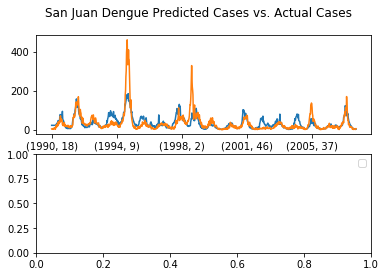

In [80]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
#iq_train['fitted'] = iq_best_model.fittedvalues
#iq_train.fitted.plot(ax=axes[1], label="Predictions")
#iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("San Juan Dengue Predicted Cases vs. Actual Cases")
plt.legend()

## Machine Learning Model for Iquitos

In [81]:
def get_best_model_two(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "prev_temp_2 + " \
                    'roll_temp + ' \
                    "prev_humid_2 + " \
                    'roll_humid + ' \
                    "prev_prec_2 + " \
                    "roll_prec + " \
                    'prev_dew_2 + ' \
                    "roll_dew + " \
                    'roll_min_temp'

    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
#sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model_two(iq_train_subtrain, iq_train_subtest)


best alpha =  1e-08
best score =  6.708333333333333


No handles with labels found to put in legend.


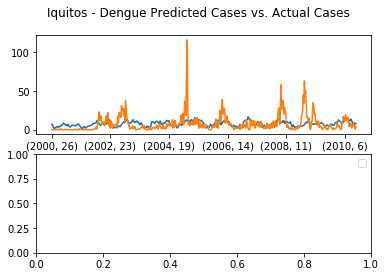

In [82]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[0], label="Predictions")
iq_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
#iq_train['fitted'] = iq_best_model.fittedvalues
#iq_train.fitted.plot(ax=axes[1], label="Predictions")
#iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Iquitos - Dengue Predicted Cases vs. Actual Cases")
plt.legend()

## Modfied version of preprocess function to only read TEST data that it has never seen - with no label data.

In [85]:
def preprocess_data(csvfile):
    df = pd.read_csv(csvfile, encoding="ISO-8859-1")
    
    #changing the data type of week_start_date to datetime format
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
     
    #Split the dataframe into two, one for San Juan and one for Iquitos
    sj = df.loc[df['city'] == 'sj',:]
    iq = df.loc[df['city'] == 'iq',:]
    
    #Fill null values using average of the values in the respective column
    sj = fillnullavg(sj)
    iq = fillnullavg(iq)
    
    # San Juan
    #add new features for San Juan that best predict increase and decrease in total cases:
    sj['roll_temp'] = sj.station_avg_temp_c.rolling(6).mean()
    sj['roll_humid'] = sj.reanalysis_relative_humidity_percent.rolling(6).mean()
    sj['roll_prec'] = sj.reanalysis_sat_precip_amt_mm.rolling(6).mean()
    sj['roll_se'] = sj.ndvi_se.rolling(6).mean()
    sj['roll_sw'] = sj.ndvi_sw.rolling(6).mean()
    sj['roll_dew'] = sj.reanalysis_dew_point_temp_k.rolling(6).mean()
    sj['roll_max_temp'] = sj.station_max_temp_c.rolling(6).mean() 
    
    # Fill all NaN
    sj = fillnullavg(sj)
    
    # Adding more features as in San Juan changes in total cases occurs weeks after changes in weather features
    sj['prev_temp_27'] = sj['roll_temp'].shift(27)
    sj['prev_temp_33'] = sj['roll_temp'].shift(33)
    sj['prev_temp_20'] = sj['roll_temp'].shift(20)
    sj['prev_temp_17'] = sj['roll_temp'].shift(17)
    sj['prev_temp_14'] = sj['roll_temp'].shift(14)
    sj['prev_temp_11'] = sj['roll_temp'].shift(11)
    sj['prev_temp_8'] = sj['roll_temp'].shift(8)
    sj['prev_temp_5'] = sj['roll_temp'].shift(5)
    sj['prev_temp_2'] = sj['roll_temp'].shift(2)
    sj['prev_humid_27'] = sj['roll_humid'].shift(27)
    sj['prev_humid_33'] = sj['roll_humid'].shift(33)
    sj['prev_humid_20'] = sj['roll_humid'].shift(20)
    sj['prev_humid_17'] = sj['roll_humid'].shift(17)
    sj['prev_humid_14'] = sj['roll_humid'].shift(14)
    sj['prev_humid_11'] = sj['roll_humid'].shift(11)
    sj['prev_humid_8'] = sj['roll_humid'].shift(8)
    sj['prev_humid_5'] = sj['roll_humid'].shift(5)
    sj['prev_humid_2'] = sj['roll_humid'].shift(2)
    sj['prev_prec_27'] = sj['roll_prec'].shift(27)
    sj['prev_prec_33'] = sj['roll_prec'].shift(33)
    sj['prev_prec_20'] = sj['roll_prec'].shift(20)
    sj['prev_prec_17'] = sj['roll_prec'].shift(17)
    sj['prev_prec_14'] = sj['roll_prec'].shift(14)
    sj['prev_prec_11'] = sj['roll_prec'].shift(11)
    sj['prev_prec_8'] = sj['roll_prec'].shift(8)
    sj['prev_prec_5'] = sj['roll_prec'].shift(5)
    sj['prev_prec_2'] = sj['roll_prec'].shift(2)
    sj['prev_dew_27'] = sj['roll_dew'].shift(27)
    sj['prev_dew_33'] = sj['roll_dew'].shift(33)
    sj['prev_dew_20'] = sj['roll_dew'].shift(20)
    sj['prev_dew_17'] = sj['roll_dew'].shift(17)
    sj['prev_dew_14'] = sj['roll_dew'].shift(14)
    sj['prev_dew_11'] = sj['roll_dew'].shift(11)
    sj['prev_dew_8'] = sj['roll_dew'].shift(8)
    sj['prev_dew_5'] = sj['roll_dew'].shift(5)
    sj['prev_dew_2'] = sj['roll_dew'].shift(2)
    
    # fill all NaN
    sj = fillnullavg(sj)
    
    # Define the training dataset that only uses the NEW FEATURES
    sj_te = sj[['year','weekofyear', 'prev_temp_33','prev_temp_27', 'prev_temp_20', 'prev_temp_17','prev_temp_14',
               'prev_temp_11', 'prev_temp_8','prev_temp_5', 'prev_temp_2', 'roll_temp', 
               'prev_humid_33','prev_humid_27', 'prev_humid_20', 'prev_humid_17','prev_humid_14', 'prev_humid_11', 
               'prev_humid_8','prev_humid_5','prev_humid_2', 'roll_humid', 
               'prev_prec_33','prev_prec_27', 'prev_prec_20','prev_prec_17','prev_prec_14', 'prev_prec_11', 
               'prev_prec_8', 'prev_prec_5', 'prev_prec_2', 'roll_prec', 
               'prev_dew_33','prev_dew_27', 'prev_dew_20','prev_dew_17', 'prev_dew_14', 'prev_dew_11','prev_dew_8', 
               'prev_dew_5','prev_dew_2', 'roll_dew']]
    
    ## Re-indexing the new training dataframe
    sj_te.set_index(['year','weekofyear'], inplace = True)
    
    
    # Iquitos
    #add new features for Iquitos that best predict increase and decrease in total cases:
    iq['roll_temp'] = iq.station_avg_temp_c.rolling(3).mean()
    iq['roll_prec'] = iq.reanalysis_relative_humidity_percent.rolling(3).mean()
    iq['roll_humid'] = iq.reanalysis_relative_humidity_percent.rolling(3).mean()
    iq['roll_dew'] = iq.reanalysis_dew_point_temp_k.rolling(3).mean()
    iq['roll_min_temp'] = iq.station_min_temp_c.rolling(3).mean()
    
    # fill all NaN
    iq = fillnullavg(iq)
    
    # Adding more features as in Iquitos changes in total cases occurs shortly after changes in weather features
    iq['prev_temp_1'] = iq['roll_temp'].shift(1)
    iq['prev_prec_1'] = iq['roll_prec'].shift(1)
    iq['prev_humid_1'] = iq['roll_humid'].shift(1)
    iq['prev_dew_1'] = iq['roll_dew'].shift(1)
    iq['prev_temp_2'] = iq['roll_temp'].shift(2)
    iq['prev_prec_2'] = iq['roll_prec'].shift(2)
    iq['prev_humid_2'] = iq['roll_humid'].shift(2)
    iq['prev_dew_2'] = iq['roll_dew'].shift(2)
    iq['prev_temp_4'] = iq['roll_temp'].shift(4)
    iq['prev_prec_4'] = iq['roll_prec'].shift(4)
    iq['prev_humid_4'] = iq['roll_humid'].shift(4)
    iq['prev_dew_4'] = iq['roll_dew'].shift(4)
    iq['prev_temp_6'] = iq['roll_temp'].shift(6)
    iq['prev_prec_6'] = iq['roll_prec'].shift(6)
    iq['prev_humid_6'] = iq['roll_humid'].shift(6)
    iq['prev_dew_6'] = iq['roll_dew'].shift(6)
    iq['prev_temp_8'] = iq['roll_temp'].shift(8)
    iq['prev_prec_8'] = iq['roll_prec'].shift(8)
    iq['prev_humid_8'] = iq['roll_humid'].shift(8)
    iq['prev_dew_8'] = iq['roll_dew'].shift(8)
    
    # fill all NaN
    iq = fillnullavg(iq)
    
    # Define the training dataset that only uses the NEW FEATURES
    iq_te = iq[['year','weekofyear',
               'prev_temp_6', 'prev_temp_4','prev_temp_2', 'prev_temp_1',
               'roll_temp',
               'prev_prec_8','prev_prec_6','prev_prec_4', 'prev_prec_2', 'prev_prec_1',
               'roll_prec',
               'prev_humid_6', 'prev_humid_4', 'prev_humid_2', 'prev_humid_1',
               'roll_humid',
               'prev_dew_8', 'prev_dew_6', 'prev_dew_4', 'prev_dew_2', 'prev_dew_1',
               'roll_dew',
               'roll_min_temp']]
    
    ## Re-indexing the new training dataframe
    iq_te.set_index(['year','weekofyear'], inplace = True)
    
    return(sj_te, iq_te)


In [86]:
sj_test, iq_test = preprocess_data('DengAI_Predicting_Disease_Spread_-_Test_Data_Features.csv')

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv("DengAI_Predicting_Disease_Spread_-_Submission_Format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("submitted/1st_benchmark.csv")

/Users/jam/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jam/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jam/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/Users/jam/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jam/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jam/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se